In [85]:
import torch
from torch import nn, optim, tensor, Tensor
from torchdiffeq import odeint, odeint_adjoint
from torchdyn.datasets import ToyDataset
import matplotlib.pyplot as plt
import progressbar
import pandas as pd
import os

In [86]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)


def autograd_trace(x_out, x_in):
    """
    `autograd_trace`:(`x_out`, `x_in`): compute the trace of the Jacobian of `x_out` w.r.t. `x_in` using autograd.
    """
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:,i].sum(), x_in, create_graph=True)[0].contiguous()[:,i].contiguous()
    return trJ.contiguous() # return the trace of Jacobian


class Planar(nn.Module):
    """
        Construct a net according to the Planar Flow: return the params of the flows:
        u, w, b
    :params `in_out_dim`: the dimension of the input and output.
    :params `hidden_dim`: the dimension of the hidden layers.
    :params `width`: the width of the flow. (The number of parallel flows) We average each flow result finally to get the final result.
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        params = t.reshape(1,1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)
        params = params.reshape(-1)

        w = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)
        u = params[self.blocksize:2*self.blocksize].reshape(self.width, 1,self.in_out_dim)
        g = params[2*self.blocksize:3*self.blocksize].reshape(self.width, 1,self.in_out_dim)
        u = u*torch.sigmoid(g)  # for some reason, we use u*sigmoid(g) instead of u directly.

        b = params[3 * self.blocksize:].reshape(self.width,1,1)
        return [w,u,b]


class CNF(nn.Module):
    """
        `CNF`: An object of the Continuous Normalizing Flow (CNF) model.
    :params `in_out_dim`: the dimension of the input and output.
    :params `hidden_dim`: the dimension of the hidden layers.
    :params `width`: the width of the flow. (The number of parallel flows) We average each flow result finally to get the final result.
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.planar = Planar(in_out_dim, hidden_dim, width)     # Instantiate the HyperNetwork, which input time t and return the params of the flow.

    # As the odeint solver requires the input of the forward function to be (t, states), we need to pass the time t as the first argument.
    # The `states` is a tuple of the states of the system. Here, we have two states: z and logp_z.
    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]     # get the batch size

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            w,u,b = self.planar(t)                              # get the params of the flow
            Z = torch.unsqueeze(z,0).repeat(self.width, 1,1)    # repeat the input z to match the width of the flow
            h = torch.tanh(torch.matmul(Z,w) + b)               # compute the hidden state h
            dz_dt = torch.matmul(h, u).mean(0)                  # compute the dz/dt
            dlogp_z_dt = -autograd_trace(dz_dt, z).view(batchsize, 1) # compute the dlogp_z/dt

        return (dz_dt, dlogp_z_dt)

In [87]:
generator = CNF(in_out_dim=2, hidden_dim=64, width=3)

In [88]:
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)

vis_z0 = p_z0.sample((9000,)).to(device)
t0 = 0
t1 = 10

# Validate the generation of six gaussians datasets

In [89]:
def get_batch(num_samples):
    points, _ = ToyDataset().generate(num_samples // 6,
                              'gaussians',
                              n_gaussians=6,
                              std_gaussians=.5,
                              radius=4,dim=2)

    X = ((points - points.mean()) / points.std()).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(X.size(0), 1).type(torch.float32).to(device)
    return (X,logp_diff_t1)
X, _ = get_batch(9000)


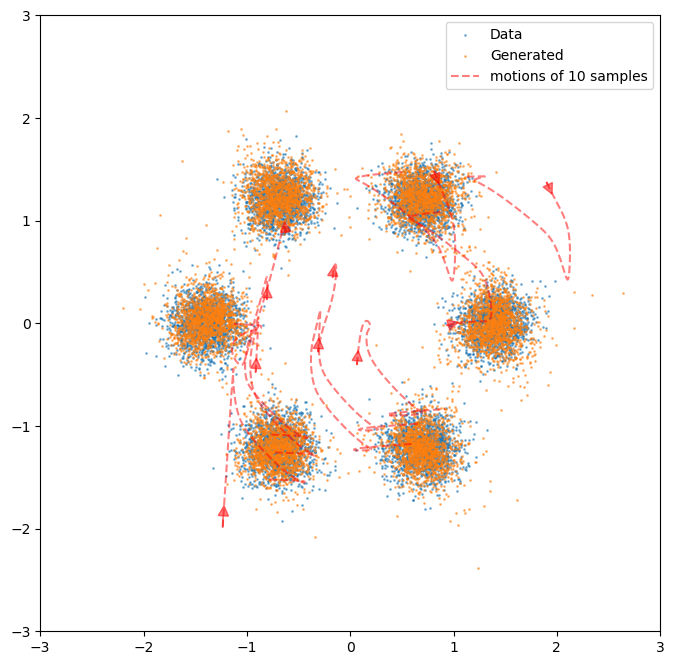

In [90]:
gaussians_checkpoint = torch.load(os.path.join(
    "./Planar/six-gaussians/six-gaussians1100.pt"), map_location=device)
generator.load_state_dict(gaussians_checkpoint["model_state_dict"])
generator.eval()

with torch.no_grad():
    vis_z1, _ = odeint(generator, (vis_z0, torch.zeros(
    vis_z0.shape[0])), torch.linspace(t0, t1,1000).float().to(device))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
s1 = ax.scatter(*X.detach().cpu().T, s=1, alpha=0.5, label="Data")
s2 = ax.scatter(*vis_z1[-1].detach().cpu().T, s=1, alpha=0.5, label="Generated")
for i in range(10):
    l = ax.plot(*vis_z1[:,i,:].T, c = "r", alpha=0.5,linestyle="--", label = "motions of 10 samples" if i == 0 else "")
    ax.arrow(*vis_z1[0,i,:].cpu(), *(vis_z1[3,i,:]-vis_z1[0,i,:]).cpu(), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# ax.legend([s1, s2], ["Data", "Generated"])
ax.legend()
plt.show()

In [91]:
# vis_z1[1:,0,:] - vis_z1[:-1,0,:]

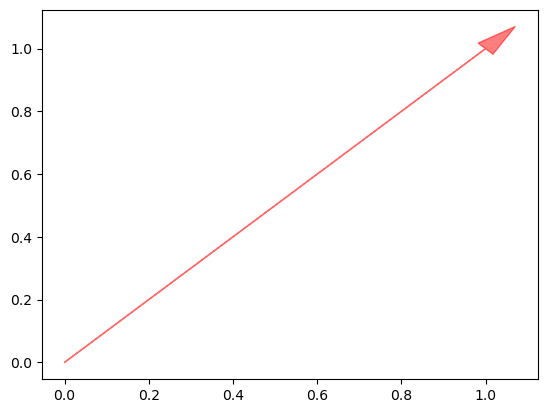

In [92]:
plt.arrow(0, 0, 1, 1, head_width=0.05, head_length=0.1, fc='r', ec='r', alpha=0.5)

# Validate the generation of moons datasets

In [93]:
def get_batch(num_samples):
    points, _ = ToyDataset().generate(
        n_samples=num_samples,
        noise=2e-1,
        dataset_type='moons')

    X = ((points - points.mean()) / points.std()).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(X.size(0), 1).type(torch.float32).to(device)

    return (X,logp_diff_t1)

X, _ = get_batch(9000)

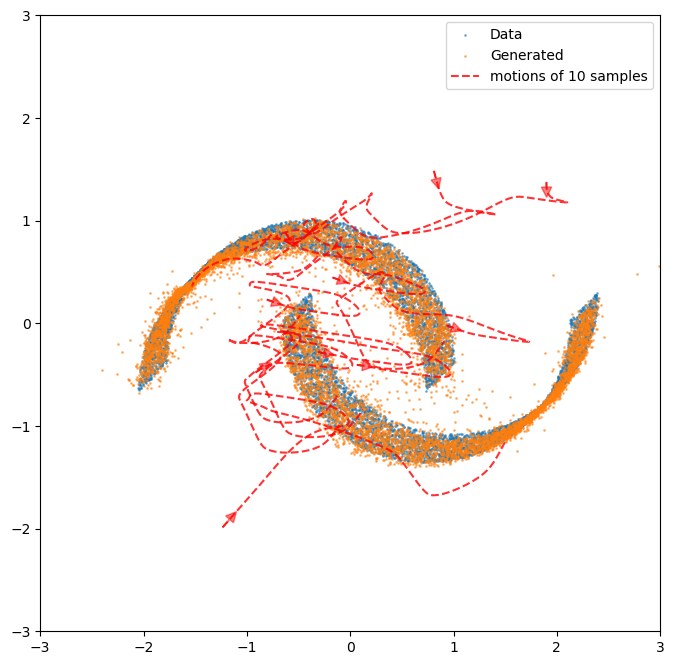

In [94]:
moons_checkpoint = torch.load(os.path.join(
    "./Planar/moons/moons11900.pt"), map_location=device)
generator.load_state_dict(moons_checkpoint["model_state_dict"])
generator.eval()
with torch.no_grad():
    vis_z1, _ = odeint(generator, (vis_z0, torch.zeros(
        vis_z0.shape[0])), torch.linspace(t0,t1,1000).float().to(device))
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
s1 = ax.scatter(*X.detach().cpu().T, s=1, alpha=0.5, label="Data")
s2 = ax.scatter(*vis_z1[-1].detach().cpu().T, s=1, alpha=0.5, label="Generated")
for i in range(10):
    l = ax.plot(*vis_z1[:,i,:].T, c = "r", alpha=0.8,linestyle="--", label = "motions of 10 samples" if i == 0 else "")
    ax.arrow(*vis_z1[0,i,:].cpu(), *(vis_z1[3,i,:]-vis_z1[0,i,:]).cpu(), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.legend()
plt.show()

# Validate the generation of spheres datasets

In [95]:
def get_batch(num_samples):
    points, _ = ToyDataset().generate(
        n_samples=num_samples,
        noise=8e-2,
        dataset_type='spheres', dim=2)

    X = ((points - points.mean()) / points.std()).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(X.size(0), 1).type(torch.float32).to(device)

    return (X,logp_diff_t1)


X, _ = get_batch(9000)

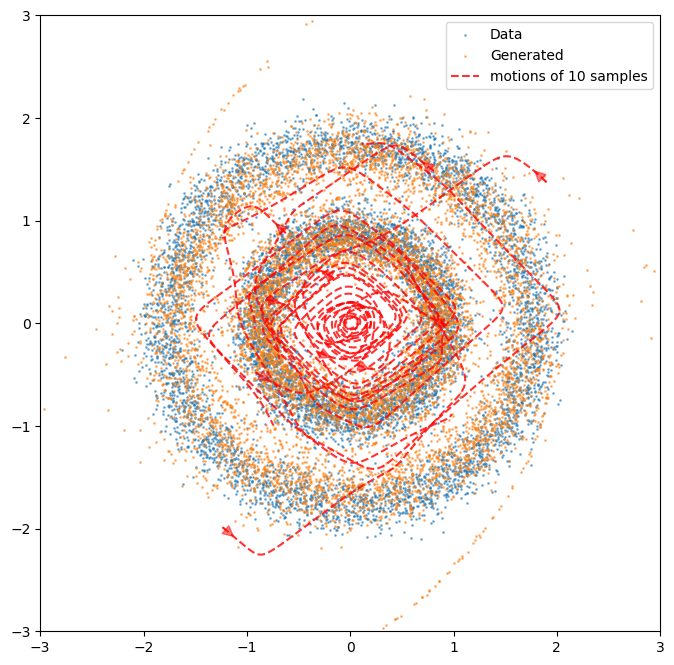

In [96]:
spheres_checkpoint = torch.load(os.path.join(
    "./Planar/spheres/spheres7100.pt"), map_location=device)
generator.load_state_dict(spheres_checkpoint["model_state_dict"])
generator.eval()

with torch.no_grad():
    vis_z1, _ = odeint(generator, (vis_z0, torch.zeros(
        vis_z0.shape[0])), torch.linspace(t0, t1,1000).float().to(device))
        
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
s1 = ax.scatter(*X.detach().cpu().T, s=1, alpha=0.5, label="Data")
s2 = ax.scatter(*vis_z1[-1].detach().cpu().T, s=1, alpha=0.5, label="Generated")
for i in range(10):
    l = ax.plot(*vis_z1[:,i,:].T, c = "r", alpha=0.8,linestyle="--", label = "motions of 10 samples" if i == 0 else "")
    ax.arrow(*vis_z1[0,i,:].cpu(), *(vis_z1[3,i,:]-vis_z1[0,i,:]).cpu(), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.legend()
plt.show()